In [16]:
import pathlib as p
from preprocessing import split_dataset, scale_to_reference_img, pad_to_shape, normalize, get_patches, reconstruct_from_patches, create_LR_img_simple
from evaluations import calculate_metrics
import nibabel as nib

# interpolated
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(DATA_DIR.rglob("*T2w_LR.nii.gz"))

patch_size = (32, 32, 32)
stride = (16, 16, 16)
target_shape = (192, 224, 192)  

files = list(zip(t1_files, t2_files, t2_LR_files))
train, val, test = split_dataset(files)
ref_img = nib.load(str(t1_files[0]))



In [2]:

train_t1, train_t2, train_t2_LR = get_patches(train, patch_size, stride, target_shape, ref_img)
val_t1, val_t2, val_t2_LR = get_patches(val, patch_size, stride, target_shape, ref_img)
test_t1, test_t2, test_t2_LR = get_patches(test, patch_size, stride, target_shape, ref_img)


real_images = []


In [3]:
interpolated_images = []
for i in range(len(test_t1)):
        
        interpolated_reconstructed = reconstruct_from_patches(test_t2_LR[i], target_shape, stride)
        interpolated_images.append(interpolated_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")

Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11


In [17]:
#IMAGE RECONSTRUCTION

# AdaDM weights: 2025-10-17T13:42:15.488869_model_weights.pth
# AdaDM weigths, instance norm on all layers except last: 2025-10-22T09:51:40.922392_model_weights.pth
# Normal Unet, no Norm: 2025-10-16T23:05:46.875504_model_weights.pth

#load Unet weights
import torch
from monai.networks.nets import UNet
#from unet import UNet
from monai.networks.layers.factories import Norm
#from unet import UNet
DATA_DIR = p.Path.home()/"data"/"bobsrepository"

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"2025-10-16T23:05:46.875504_model_weights.pth", map_location="cpu"))

generated_images = []
real_images = []
net.eval()
with torch.no_grad():
    for i in range(len(test_t1)):
        all_outputs = []
        for j in range(len(test_t1[0])):
            input1 = torch.tensor(test_t1[i][j]).float()
            input2 = torch.tensor(test_t2_LR[i][j]).float()
            inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 64, 64, 64)
            output = net(inputs)
            all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)
        gen_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)
        real_reconstructed = reconstruct_from_patches(test_t2[i], target_shape, stride)
        generated_images.append(gen_reconstructed)
        real_images.append(real_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")



Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11


In [5]:
#calculate metrics
metrics = calculate_metrics(real_images, generated_images)
print(f"Generated - PSNR: {metrics['psnr']}, SSIM: {metrics['ssim']}, NRMSE: {metrics['nrmse']}, MSE: {metrics['mse']}")


Generated - PSNR: 36.17959645010073, SSIM: 0.9876904574290396, NRMSE: 0.05881507161829132, MSE: 0.00024625267934256026


In [6]:
#implement lpips

from monai.losses.perceptual import PerceptualLoss, MedicalNetPerceptualSimilarity

lpips_loss = MedicalNetPerceptualSimilarity()

import torch

# Convert numpy arrays to torch tensors and add batch and channel dimensions
real_tensor = torch.tensor(real_images[0]).unsqueeze(0).unsqueeze(0).float()
gen_tensor = torch.tensor(generated_images[0]).unsqueeze(0).unsqueeze(0).float()
interp_tensor = torch.tensor(interpolated_images[0]).unsqueeze(0).unsqueeze(0).float()


gen_lpips = lpips_loss(real_tensor, gen_tensor)
interp_lpips = lpips_loss(real_tensor, interp_tensor)

print(f"LPIPS - Generated: {gen_lpips.item()}, Interpolated: {interp_lpips.item()}")


LPIPS - Generated: 3.347777692397358e-06, Interpolated: 3.136690429528244e-05


In [10]:
generated_adadm = generated_images


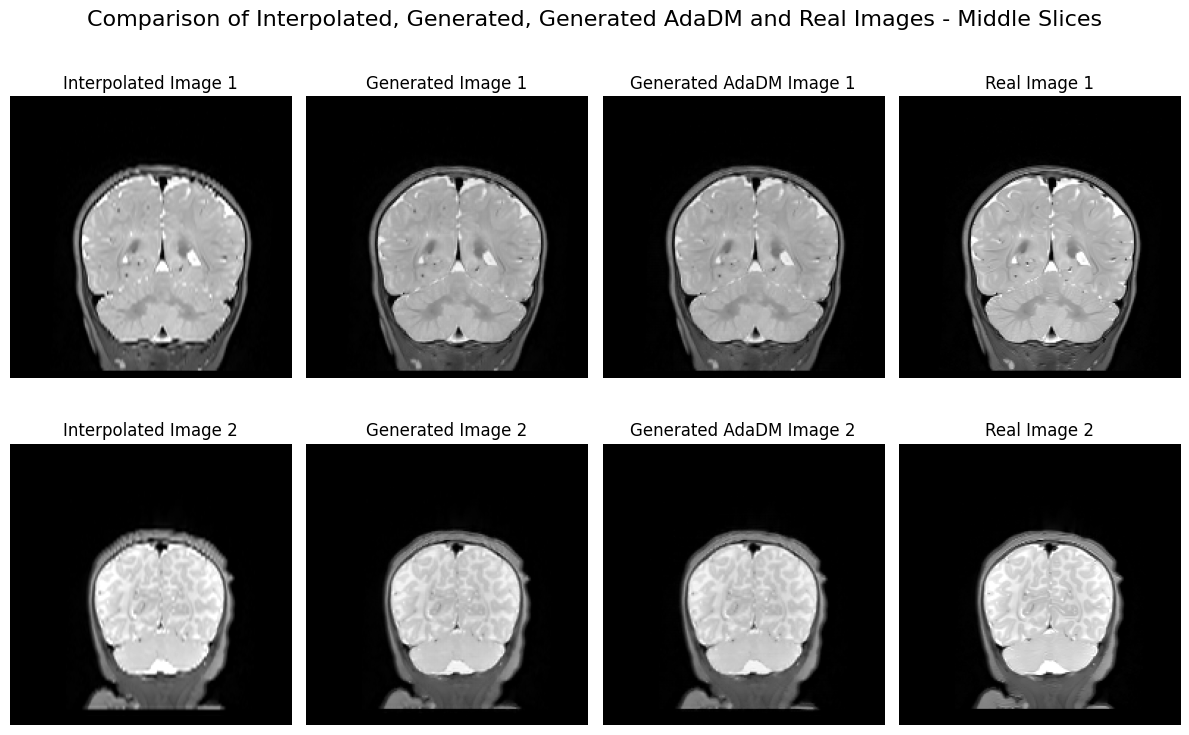

In [ ]:
#visualize adadm results
#plot middle slice of interpolated_images, generated_images, generated_adadm and real_images in a grid for comparison, first 2 images. image typs as columns, image index as rows
import matplotlib.pyplot as plt
import numpy as np

#turn image 90 degrees anti clockwise for correct orientation
interpolated_images = [np.rot90(img, k=1, axes=(0, 2)) for img in interpolated_images]
generated_images = [np.rot90(img, k=1, axes=(0, 2)) for img in generated_images]
generated_adadm = [np.rot90(img, k=1, axes=(0, 2)) for img in generated_adadm]
real_images = [np.rot90(img, k=1, axes=(0, 2)) for img in real_images]

num_images = 2
cols = 4
rows = num_images
plt.figure(figsize=(12, 8))
for i in range(num_images):
    plt.subplot(rows, cols, i * cols + 1)
    mid_slice = interpolated_images[i].shape[2] // 2
    #flip the slice for correct orientation
    plt.imshow(interpolated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Interpolated Image {i+1}")
    
    plt.subplot(rows, cols, i * cols + 2)
    mid_slice = generated_images[i].shape[2] // 2
    plt.imshow(generated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")

    plt.subplot(rows, cols, i * cols + 3)
    mid_slice = generated_adadm[i].shape[2] // 2
    plt.imshow(generated_adadm[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Generated AdaDM Image {i+1}")

    plt.subplot(rows, cols, i * cols + 4)
    mid_slice = real_images[i].shape[2] // 2
    plt.imshow(real_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Real Image {i+1}")
plt.suptitle('Comparison of Interpolated, Generated, Generated AdaDM and Real Images - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()


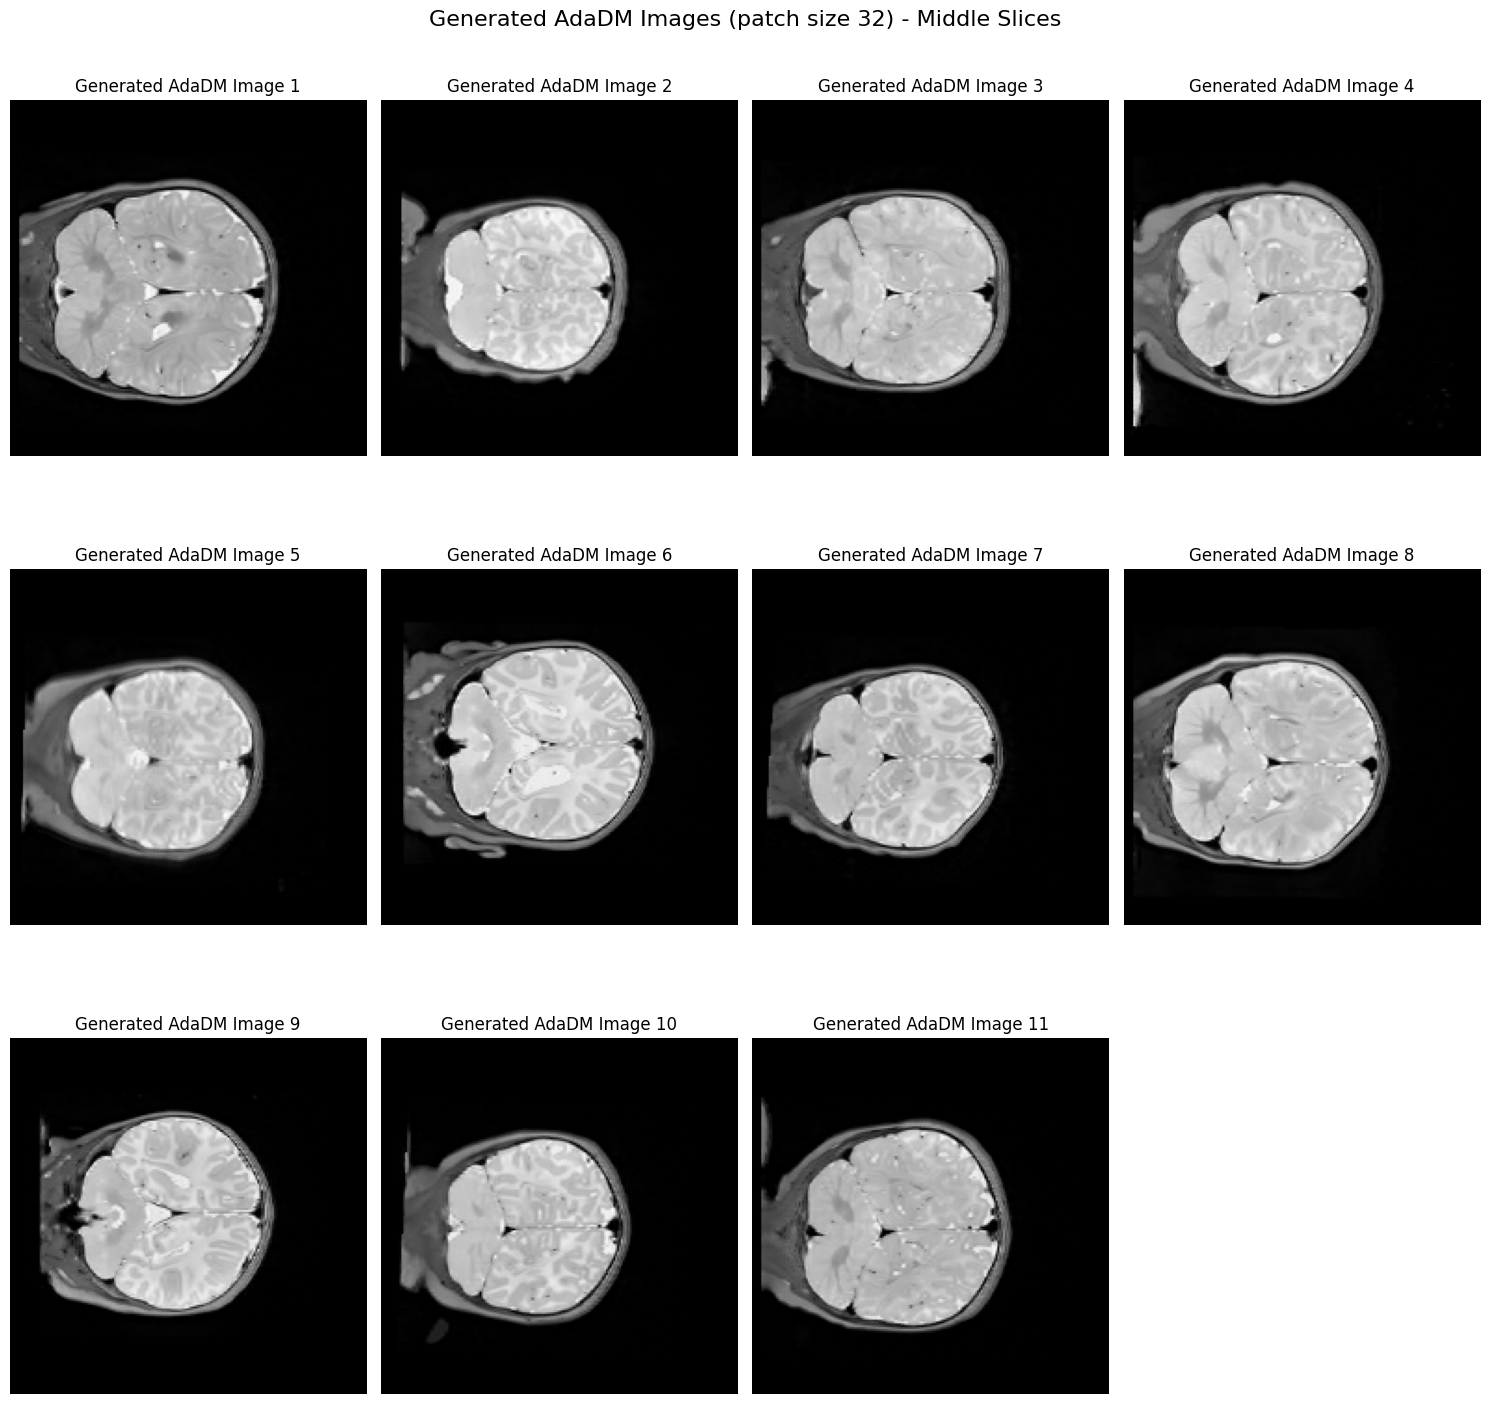

In [ ]:
# plot all test adadm


#plot the middle slice of all images in a grid
import matplotlib.pyplot as plt
import numpy as np
num_images = len(generated_adadm)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = generated_adadm[i].shape[2] // 2
    plt.imshow(generated_adadm[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Generated AdaDM Image {i+1}")
plt.suptitle('Generated AdaDM Images (patch size 32) - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()



In [58]:
#make adadm generated to nifti files
output_dir = DATA_DIR/"generated_images"/"adadm_generated_nifti"
output_dir.mkdir(parents=True, exist_ok=True)
for i, img in enumerate(generated_adadm):
    nifti_img = nib.Nifti1Image(img, affine=ref_img.affine)
    nib.save(nifti_img, output_dir/f"adadm_generated_image_{i+1}.nii.gz")
